# Oficina 9: Análise de sentimento com o dataset “Sentiment Labelled Sentences”

## 1. Bibliotecas

In [72]:
import pandas as pd
import string
from sklearn.model_selection import train_test_split # Para separa o dataset entre treino e testes
from sklearn.feature_extraction.text import TfidfVectorizer #Para padronização do teesto, transforma em números, calcular o TF-ID
from sklearn.naive_bayes import MultinomialNB # Modelo de classificação, Naive Bayes, baseado no teorema de Bayes.
from sklearn.pipeline import Pipeline #Pra combina as etapas de pré-procesamento e modelagem

from sklearn.metrics import accuracy_score #caucula a acurácia do modelo
                                     #Agora estou aplicando tudo q foi orientado e pesquisado(quase tudo).
import nltk #PLN
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import confusion_matrix

import re #Pra limpeza do texto

import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
from nltk.corpus import stopwords
nltk.download('stopwords') #Lista de palavras consideradas irrelevantes
nltk.download('wordnet') #organização estruturada das informações lexicais (conjunto de sinônimos, antônimo...)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 2.Pré-processamento

In [60]:
df = pd.read_csv('/content/amazon_cells_labelled.txt', sep='\t', header=None)
df.columns = ['text', 'sentiment']

text = df['text']
text.head()

,text
0,So there is no way for me to plug it in here i...
1,"Good case, Excellent value."
2,Great for the jawbone.
3,Tied to charger for conversations lasting more...
4,The mic is great.


### Limpeza

In [61]:
# Removemdo caracteres especiais e pontuação
def preprocess_text(text):
  text = text.lower() #Formatando o texto para minúsculas

  text = re.sub(r'http\S+', '', text)  # Remove URLs
  text = re.sub(r'@\S+', '', text)   # Remove menções (@)
  text = re.sub(r'#\S+', '', text)   # Remove hashtags (#)
  text = re.sub(r'\d+', '', text)   # Remove números
  text = re.sub(r'[^\w\s]', '', text)  # Remove caracteres especiais
  text = re.sub(r'\s+', ' ', text)  # Remove espaços em branco adicionais

  text = text.translate(str.maketrans('', '', string.punctuation)) # Removendo pontuação
  text = text.strip() # Removendo espaços em branco

  words = [word for word in text.split() if word not in stopwords.words('english')]  # Remover stopwords
  return " ".join(words)


### Vetorização

> Utilizamos a técnica TfidfVectorizer para converter os textos em matrizes de características numéricas, o que permite que a importância de cada palavra em um texto seja calculada por meio de sua frequência no texto. Dessa forma, é possível identificar a importância de cada palavra em um documento.

Essa parte do pré-processamento é importante por:
* Remover ruídos que atrapalham o modelo;
* Transforma letras em minúsculas, remove acentos
* Divide em unidades menores (tokenização) e reduz palavras à sua forma base (lematização/radicalização).

Ou seja, padroniza os dados para o modelo entender o sentimento com mais orecisão.



In [62]:
df['text'] = df['text'].apply(preprocess_text)

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(text)

print(f'Matriz: {X}\n')
print(vectorizer.vocabulary_)

Matriz:   (0, 1491)	0.19164819187071502
  (0, 1609)	0.22925438486351277
  (0, 854)	0.11680650225372383
  (0, 1074)	0.21424736019492926
  (0, 1766)	0.2663000442108417
  (0, 653)	0.1449316337525006
  (0, 993)	0.20746710112948877
  (0, 1640)	0.12694625638326024
  (0, 1212)	0.24777721453717727
  (0, 857)	0.10744287763403453
  (0, 814)	0.3156148341874833
  (0, 762)	0.2877711819152493
  (0, 1604)	0.09065770616075083
  (0, 1714)	0.31110718748699573
  (0, 1702)	0.2979650306857509
  (0, 711)	0.2724001479983455
  (0, 233)	0.26091937133842197
  (0, 367)	0.32963001716066015
  (1, 715)	0.3752776975307017
  (1, 259)	0.4710276120116065
  (1, 569)	0.47823718132718357
  (1, 1733)	0.6392095406476104
  (2, 653)	0.38588437172802004
  (2, 1604)	0.24137858022000805
  (2, 721)	0.4042788970415545
  :	:
  (997, 474)	0.40169250815766483
  (997, 858)	0.4243537646888628
  (997, 989)	0.5633661621231332
  (998, 854)	0.13470046941284514
  (998, 993)	0.23924965965645484
  (998, 1604)	0.20909170876838937
  (998, 1602)

### Pipeline

> Escolhi o modelo Naive Bays por ser específico para dados textuais, ele aprende e classificar os textos em categorias positicas ou negativas. Naive Bayes é rápido para treinar e classificar, e funciona bem com dados de contagem de palavras, como os gerados pelo TfidfVectorizer.

In [63]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

pipeline.fit(text, df['sentiment'])

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('classifier', MultinomialNB())])

In [64]:
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()

model.fit(X_train, y_train)

MultinomialNB()

> O modelo Naive Bayes aprende a classificar comentários com base na probabilidade de cada palavra aparecer em textos com sentimentos positivos ou negativos.

Exemplo: Ele aprende que palavras como "adorei", "bom" e "muito" são mais prováveis de aparecer em textos positivos, enquanto palavras como "horrível", "não gostei" e "nada" são mais prováveis de aparecer em textos negativos.

## Avaliar o Modelo

In [69]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy}')

Acurácia: 0.855


>A acurácia de 0.855 nos diz que o seu modelo de classificação de sentimentos está prevendo corretamente o sentimento (positivo ou negativo) de um comentário em 85,5% dos casos, no conjunto de teste.

> Ou seja, de cada 100 comentários no conjunto de teste, o modelo classificou corretamente o sentimento de aproximadamente 85 deles, e errou por folta do 15.

In [70]:
cm = confusion_matrix(y_test, y_pred)

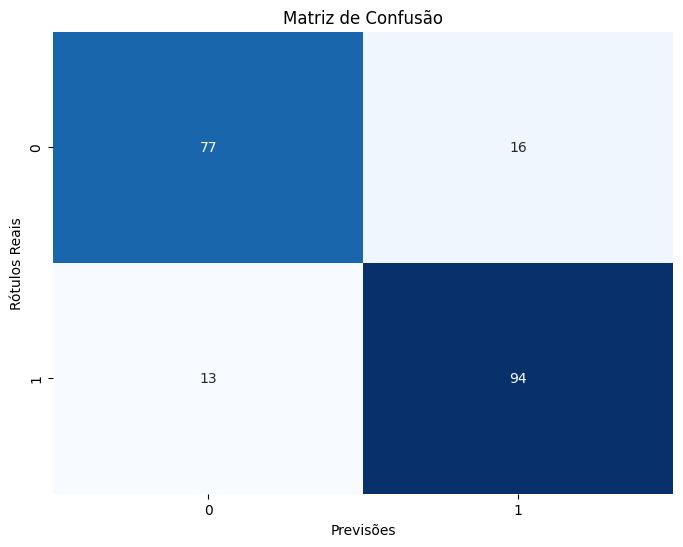

In [73]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Previsões')
plt.ylabel('Rótulos Reais')
plt.title('Matriz de Confusão')
plt.show()

